# Our Solution for the Grover Challange

Now that we explained how our algorithm works in the README file, we need to do the following:

- implement the oracle that checks for the properties discussed in the README
- implement the diffuser for the grover search
- implement the circuit
- simulate on different machines

## First we implement the functions we need:

We start by importing the modules we need:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram


One important operation that we have to use in our algorithm is the following: having two qubits, we have to check if they are different. Therefore we implement a gate that checks this by using the CNOT Gate:

In [3]:
def XOR():
    qc = QuantumCircuit(3, name='XOR')
    qc.cx(0, 2)
    qc.cx(1, 2)
    X = qc.to_gate()
    X.name = "XOR"
    return X

### We need to implement the oracle, therefore we define a new gate:

We also have to remind ourselves that the task is the following:
Having 4 pairs of qubits we need to do checks on a possible solution to mark only the configurations in which:
1. the nodes in the list are connnected by edges existing in the graph
2. use all the nodes once and only once

As a notation, we will explain the oracle by representing the qubits in the following way:
*ax by cz yt*, where ax is the binary representation of the value of the first node, etc

Therefore the checks described above are transformed into:
1. check if a differs from b, b differs from c, c differs from d
2. check that x differs from z (implying that ax will differ from cz) and y differs from t


In [4]:
# check the cycle
def oracle():
    varq = QuantumRegister(8, name='v') # the qubits used for the actual encoding
    comp_f = QuantumRegister(3, name='f') # auxiliary bits for the "first check"
    aux_dif = QuantumRegister(2, name='d') # auxiliary bits needed for the second chack
    true_out = QuantumRegister(1, name='true') # bit that helps us perform the phase-kickback trick

    qc = QuantumCircuit(varq, comp_f, aux_dif, true_out)
    
    # for the first check we have to compare pairs 0-2, 2-4, 4-6. therefore we iterate through these values and apply our
    # earlier-defined gate:
    for i in range(3):
        qc.append(XOR(), [i*2, (i+1)*2, comp_f[i]])

    # for the second check, we need 1-5 and 3-7 to differ:
    qc.append(XOR(), [1, 5, aux_dif[0]])
    qc.append(XOR(), [3, 7, aux_dif[1]])

    # and change the true_out only if our configuration is a solution <=> if all the checks are passed <=> if all checks return 1
    # therefore we use the multi-controlled toffoli to perform this check with control-qubits as our previously calculated values
    qc.mct([comp_f[0], comp_f[1], comp_f[2], aux_dif[0], aux_dif[1]], true_out)

    # we reset the auxiliary bits by reaplying the operations:
    for i in range(3):
        qc.append(XOR(), [i*2, (i+1)*2, comp_f[i]])

    qc.append(XOR(), [1, 5, aux_dif[0]])
    qc.append(XOR(), [3, 7, aux_dif[1]])

    qc.draw('mpl')
    
    # we convert our oracle to a gate so we can add it easier to the circuit:
    Oracle = qc.to_gate()
    Oracle.name = "oracle"
    return Oracle

We also need a diffuser for grover:

In [5]:
# the diffuser for the grover search 
def diffuser(nqubits):
    # the general case for nqubits number of qubits
    qc = QuantumCircuit(nqubits)
    
    # apply Hadamard to each element
    for qubit in range(nqubits):
        qc.h(qubit)
        
    # apply the transform NOT ( |00..0> -> |11...1>
    for qubit in range(nqubits):
        qc.x(qubit)

    # do multi - controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi controlled-tofolli
    qc.h(nqubits-1)

    # apply |11...1> -> |00...0>
    for qubit in range(nqubits):
        qc.x(qubit)

    # apply |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)

    U_s = qc.to_gate()
    U_s.name = "diffuser"
    return U_s

## Now we build the circuit:

In [6]:
nQubits = 14
varq = QuantumRegister(8, name='v')
comp_f = QuantumRegister(3, name='f')
aux_dif = QuantumRegister(2, name='d')
true_out = QuantumRegister(1, name='true')

cBits = ClassicalRegister(8, name='c')

qc = QuantumCircuit(varq, comp_f, aux_dif, true_out, cBits)
# qc.draw('mpl')

We initialize the qubits as follows:
- we put the varq register in a superposition to encode "all possible solutions" and allow for phase kickback
- we put the true_out state in a |-> in order to use the phase kickback trick as well

Also, since we have multiple solutions, we calculated that 6 iterations would be enough to have our result:

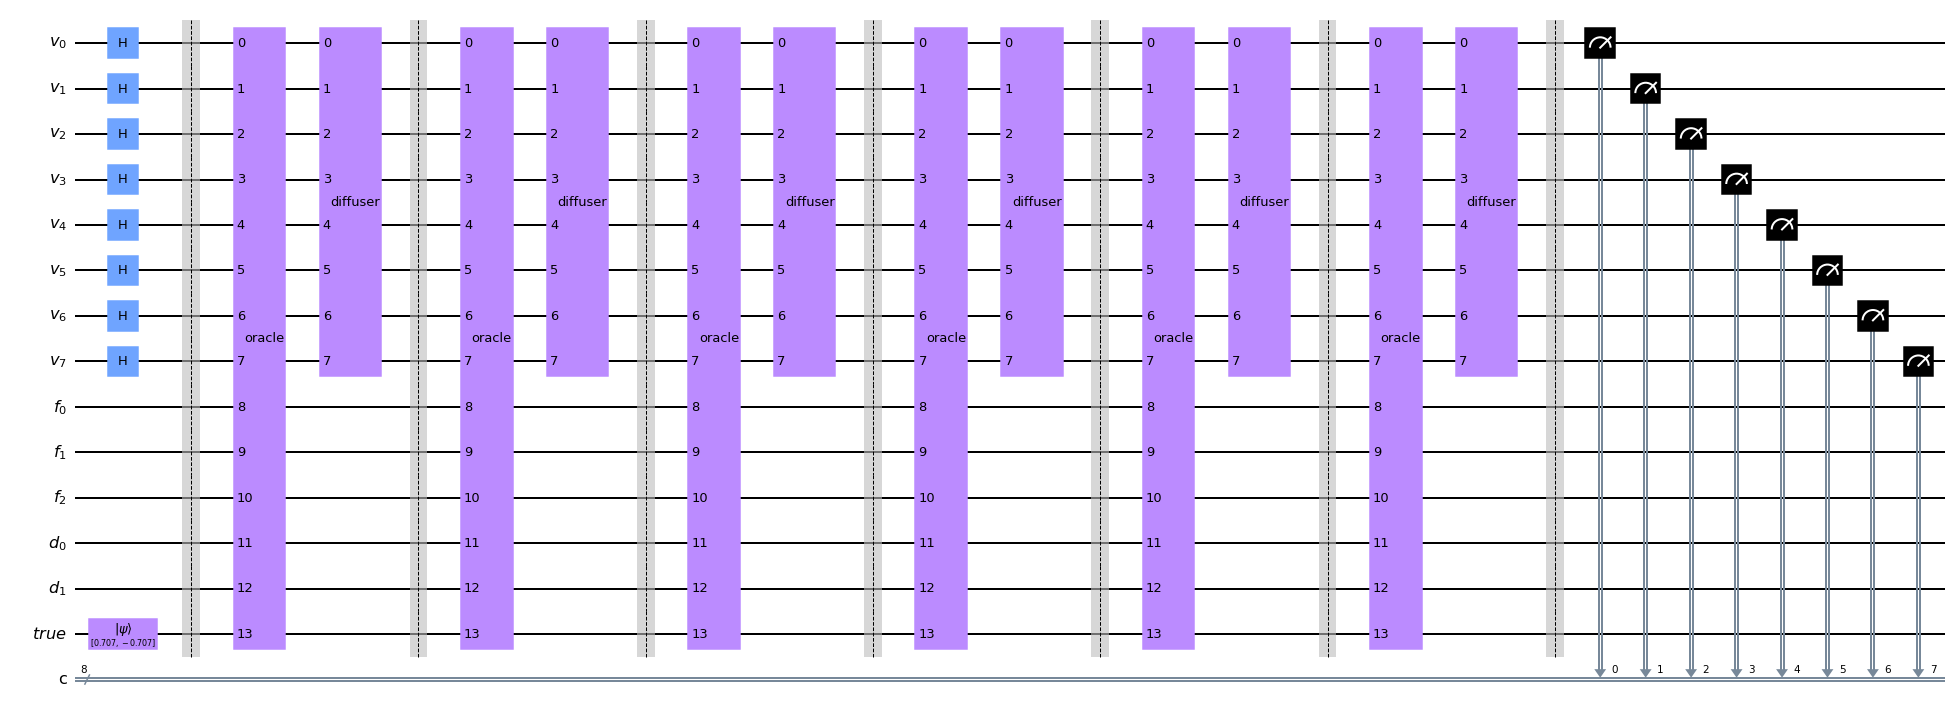

In [7]:
# initialize for the phasekickback trick:
qc.initialize([1, -1]/np.sqrt(2), true_out) # |->
qc.h(varq)

qc.barrier()

for iteration in range(6):
    qc.append(oracle(), [i for i in range(nQubits)]) 
    qc.append(diffuser(8), [i for i in range(8)])
    qc.barrier()

qc.measure(varq, cBits)
qc.draw('mpl', fold=-1)

Yey! now that we build the circuit for the problem, the next step is to see if it produces our expected results.

In [8]:
solution_vis = []

# Simulate the results:

First we check what devices are available:

In [9]:
from qbraid import get_devices

In [10]:
get_devices()

Provider,Name,qBraid ID,Status
AWS,Braket Default Simulator,aws_braket_default_sim,●
AWS,Density Matrix Simulator,aws_dm_sim,●
AWS,State Vector Simulator,aws_sv_sim,●
AWS,Tensor Network Simulator,aws_tn_sim,●
D-Wave,Advantage_system4,aws_dwave_advantage_system4,●
D-Wave,DW_2000Q_6,aws_dwave_2000Q_6,●
Google,Bristlecone,google_bristlecone,○
Google,Cirq Density Matrix Simulator,google_cirq_dm_sim,●
Google,Cirq Sparse Simulator,google_cirq_sparse_sim,●
Google,Foxtail,google_foxtail,○


## Our first choice is the ibmq simulator

For these there is no need to transpile the circuit since it is already in qiskit.

In [11]:
IBMQ.save_account('d98256ab7eccd9dc45cefaeb393c900335893f9cbf9bb3f3d25bdba7928f536a5774a474699b7e6639b9d887fa71dbad5acb7a4439fc394fdf379653670c5e80')

configrc.store_credentials:WARNING:2022-04-10 09:30:43,348: Credentials already present. Set overwrite=True to overwrite.


We use the very-useful functions provided by qbraid to run the simulations:

In [12]:
from qbraid import device_wrapper, retrieve_job
from qbraid.api import ibmq_least_busy_qpu, update_config

In [13]:
qbraid_device = device_wrapper("ibm_aer_qasm_sim")

We run the job:

In [14]:
shots = 2**10

qbraid_ibmq_job = qbraid_device.run(qc, shots=shots)
# qbraid_job.vendor_jlo  # vendor job-like-object
qbraid_ibmq_job.status()


<JobStatus.COMPLETED: 6>

In [15]:
qbraid_ibmq_result = qbraid_ibmq_job.result()


And plot the results:

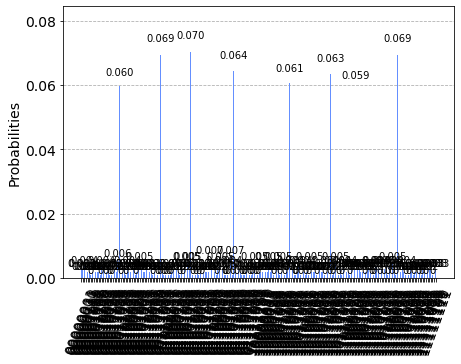

In [16]:
qbraid_ibmq_result.plot_counts()

 Next, we convert the solution to the requested format

In [17]:
# sort by most probable soltuion based on the counts from the simulation
fResults = qbraid_ibmq_result.measurement_counts()
sortF = dict(sorted(fResults.items(), key=lambda item: item[1]))
res =dict(reversed(list(sortF.items())))

# get the best one:
oneSolution =  list(res)[0]

# convert it to the form we need:
solution = [4]
for i in range(4):
    val = (int)(oneSolution[i*2])+(int)(oneSolution[i*2+1])*2
    solution.append(val)
solution.append(4)

solution_vis.append(solution)

print(solution)



[4, 2, 0, 3, 1, 4]


We can also check the solution by using the auto_grader:

In [18]:
import auto_grader
import networkx as nx


graph = nx.Graph()
graph.add_nodes_from([0,1,2,3,4])
graph.add_edges_from([(0, 4), (0, 3), (0, 2), (1, 2), (1, 4), (1, 3), (2, 4), (3, 4)])

from auto_grader import is_hamiltonian_cycle
is_hamiltonian_cycle(graph,solution)


Success: path is a Hamiltonian cycle


True

Yey!! The solution picked by grover is correct

## Next, we choose to simulate using the amazon braket simulators

For this, we first need to transpile the circuit. Since we use qustom gates we choose to do this first with the already built-in function from qiskit in order to convert the circuit to basis states.

In [19]:
from qbraid import circuit_wrapper, SUPPORTED_PROGRAM_TYPES
from qbraid.interface import to_unitary, circuits_allclose, draw


In [20]:
# transpile the circuit to use only basis gates that are recognized by braket as well:
transpiled_qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'h', 'x', 'cx']) 

In [21]:
wrapped_circuit = circuit_wrapper(transpiled_qc)
print(f"{type(wrapped_circuit)}\n")

<class 'qbraid.transpiler.wrappers.qiskit_circuit.QiskitCircuitWrapper'>



In [22]:
braket_circuit = wrapped_circuit.transpile("braket")
print(f"{type(braket_circuit)}")
# print(braket_circuit)

<class 'braket.circuits.circuit.Circuit'>


In [23]:
# we choose the device_wrapper:
qbraid_aws_device = device_wrapper("aws_braket_default_sim")

Next, we run the job:

In [24]:
qbraid_aws_job = qbraid_aws_device.run(braket_circuit, shots=shots)

In [25]:
qbraid_aws_result = qbraid_aws_job.result()


Just as before we plot the results:

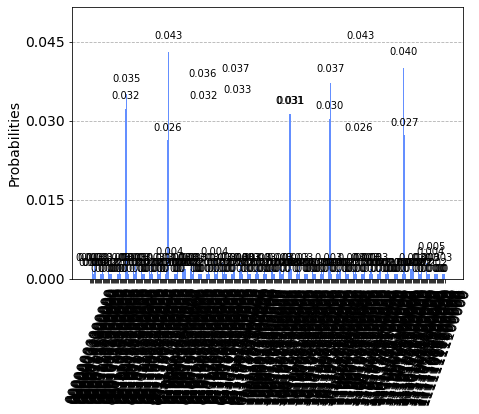

In [26]:
qbraid_aws_result.plot_counts()

And print the output in the required format:

In [27]:
fResults = qbraid_aws_result.measurement_counts()
sortF = dict(sorted(fResults.items(), key=lambda item: item[1]))
res =dict(reversed(list(sortF.items())))

oneSolution =  list(res)[0]

solution = [4]
for i in range(4):
    val = (int)(oneSolution[i*2])+(int)(oneSolution[i*2+1])*2
    solution.append(val)
solution.append(4)


solution_vis.append(solution)

print(solution)


[4, 0, 3, 1, 2, 4]


And check with the autograder as well:

In [28]:
is_hamiltonian_cycle(graph,solution)


Success: path is a Hamiltonian cycle


True

Yey! It works on aws as well!

## Improvements

#### Our circuit contains 14 qubits to reach the solution. Can we do better?

The observation that helps us with this is similar to the previous ones. Recall the notation of the states and the checks that we imposed:


*Having 4 pairs of qubits we need to do checks on a possible solution to mark only the configurations in which:*

*1. the nodes in the list are connnected by an edge*

*2. use all the nodes once and only once*


*As a notation, we will explain the oracle by representing the qubits in the following way:*

*ax by cz yt, where ax is the binary representation of the value of the first node, etc*

*Therefore the checks described above are transformed into:*

*1. check if a differs from b, b differs from c, c differs from d*

*2. check that x differs from z (implying that ax will differ from cz) and y differs from t*


If we impose that ax differs from cz as well as by differs from yt, an improvement would be to find using the grover search solution to only the first 4 qubits and construct the actual result from there.

## First try at optimizing: using 6 qubits 

Based on the observations noted above we can try the following arhitecture:
- 4 qubits to encode only the first two nodes for a solution
- 1 qubit for the XOR gate
- 1 qubit for the qubit that helps at phase kick_back(true_out)

The oracle function would also be changed:

In [29]:

# check the cycle
def oracle_optimized():
    varq = QuantumRegister(4, name='v') # the qubits used for the actual encoding
    comp_f = QuantumRegister(1, name='f') # auxiliary bits for the "first check"
    true_out = QuantumRegister(1, name='true') # bit that helps us perform the phase-kickback trick

    qc = QuantumCircuit(varq, comp_f, true_out)
    
    # for the simplified version we need to only check if the first "digits" differ:
    qc.append(XOR(), [0, 2, comp_f[0]])
    
    # and change the true_out only if our configuration is a solution <=> if all the checks are passed <=> if all checks return 1
    # in our oprimized version, this means a controlled-not on the true_out bit
    qc.mct([comp_f[0]], true_out)

    #reset:
    qc.append(XOR(), [0, 2, comp_f[0]])

    qc.draw('mpl')
    
    # we convert our oracle to a gate so we can add it easier to the circuit:
    Oracle = qc.to_gate()
    Oracle.name = "oracle"
    return Oracle

Create the circuit:

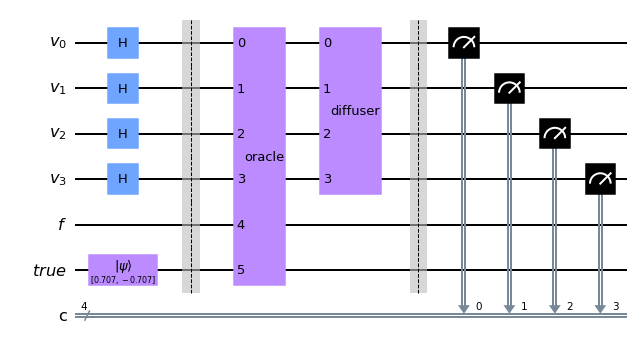

In [30]:
nQubits = 6
varq = QuantumRegister(4, name='v')
comp_f = QuantumRegister(1, name='f')
true_out = QuantumRegister(1, name='true')

cBits = ClassicalRegister(4, name='c')

qc2 = QuantumCircuit(varq, comp_f, true_out, cBits)
# initialize for the phasekickback trick:
qc2.initialize([1, -1]/np.sqrt(2), true_out) # |->
qc2.h(varq)

qc2.barrier()

for iteration in range(1):
    qc2.append(oracle_optimized(), [i for i in range(nQubits)]) 
    qc2.append(diffuser(4), [i for i in range(4)])
    qc2.barrier()

qc2.measure(varq, cBits)
qc2.draw('mpl', fold=-1)

Simulate the circuit:

In [31]:
shots = 2**20 # increase the number of shots for results to be accurate

qbraid_ibmq_job = qbraid_device.run(qc2, shots=shots)
# qbraid_job.vendor_jlo  # vendor job-like-object
qbraid_ibmq_job.status()

<JobStatus.COMPLETED: 6>

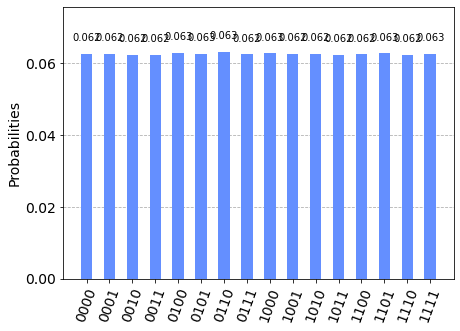

In [32]:
qbraid_ibmq_result = qbraid_ibmq_job.result()
qbraid_ibmq_result.plot_counts()

As we can see, the results don't produce a viable solution. Even though by calculating with the formula how many iterations we need for the grover search (sqrt(m/n)), we didn't get good results. We think this happens because the restraints are too loose on the solution, <b>half of the possibilities being correct solutions</b>. This means that the Reflection "about the average amplitude" doesn't have an readeable effect on the superposition of states.

<b>Solution? </b> Because the challange asks us to give only one possible cycle, we can impose more restrictions on what we want our solution to be (this of course entails that we use a few more qubits)

## Second try at optimizing: using 8 qubits 

We could also ask to receive the solution in which not only the pair (0, 2) differs, but (1, 3) and (0, 1) as well (we arrived at this conclusions after multiple tests). 

*<u>Of course, there are some downsides to this solution which we will discuss in the following section: Discussions</u>*

We implement the oracle:

In [33]:

# check the cycle
def oracle_optimized():
    varq = QuantumRegister(4, name='v') # the qubits used for the actual encoding
    comp_f = QuantumRegister(3, name='f') # auxiliary bits for the "first check"
    true_out = QuantumRegister(1, name='true') # bit that helps us perform the phase-kickback trick

    qc = QuantumCircuit(varq, comp_f, true_out)
    
    # check if the chosen pairs differ:
    qc.append(XOR(), [0, 2, comp_f[0]])
    qc.append(XOR(), [1, 3, comp_f[1]])
    qc.append(XOR(), [0, 1, comp_f[2]])
    # and change the true_out only if our configuration is a solution <=> if all the checks are passed <=> if all checks return 1
    # in our oprimized version, this means a controlled-not on the true_out bit
    qc.mct([comp_f[0], comp_f[1], comp_f[2]], true_out)

    #reset:
    qc.append(XOR(), [0, 2, comp_f[0]])
    qc.append(XOR(), [1, 3, comp_f[1]])
    qc.append(XOR(), [0, 1, comp_f[2]])

    qc.draw('mpl')
    
    # we convert our oracle to a gate so we can add it easier to the circuit:
    Oracle = qc.to_gate()
    Oracle.name = "oracle"
    return Oracle

In [34]:
nQubits = 8
varq = QuantumRegister(4, name='v')
comp_f = QuantumRegister(3, name='f')
true_out = QuantumRegister(1, name='true')

cBits = ClassicalRegister(4, name='c')

qc2 = QuantumCircuit(varq, comp_f, true_out, cBits)


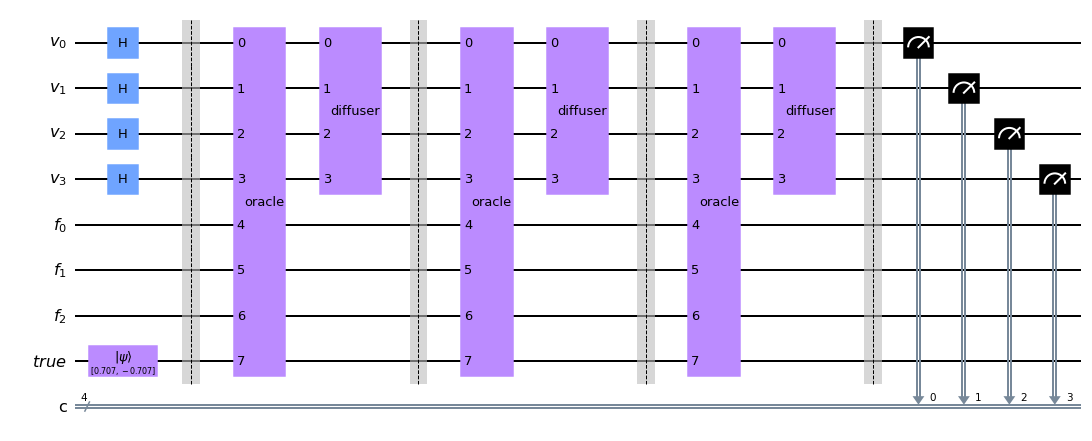

In [35]:
# initialize for the phasekickback trick:
qc2.initialize([1, -1]/np.sqrt(2), true_out) # |->
qc2.h(varq)

qc2.barrier()

for iteration in range(3):
    qc2.append(oracle_optimized(), [i for i in range(nQubits)]) 
    qc2.append(diffuser(4), [i for i in range(4)])
    qc2.barrier()

qc2.measure(varq, cBits)
qc2.draw('mpl', fold=-1)

### Simulate on different devices:

#### 1. IBMQ simulator

In [36]:
shots = 2**10

qbraid_ibmq_job = qbraid_device.run(qc2, shots=shots)
# qbraid_job.vendor_jlo  # vendor job-like-object
qbraid_ibmq_job.status()

<JobStatus.COMPLETED: 6>

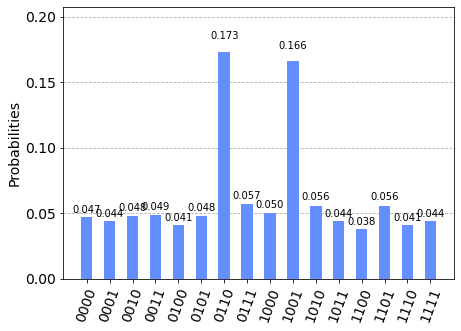

In [37]:
qbraid_ibmq_result = qbraid_ibmq_job.result()
qbraid_ibmq_result.plot_counts()

In [38]:
# sort by most probable soltuion based on the counts from the simulation
fResults = qbraid_ibmq_result.measurement_counts()
sortF = dict(sorted(fResults.items(), key=lambda item: item[1]))
res =dict(reversed(list(sortF.items())))

# get the best one:
oneSolution =  list(res)[0]

# convert it to the form we need:
solution = [4]
for i in range(2):
    val = (int)(oneSolution[i*2])+(int)(oneSolution[i*2+1])*2
    solution.append(val)

# to construct the solution we add the remaining nodes on the already established rule
# they have the same starting bit as the ones from one bit before and have different second-bit value 
# (this is the reason we convert it using 1-(int)(oneSolution[i*2])
for i in range(2):
    solution.append((1-(int)(oneSolution[i*2]))+(int)(oneSolution[i*2+1])*2)

solution.append(4)

solution_vis.append(solution)

print(solution)


[4, 2, 1, 3, 0, 4]


In [39]:
is_hamiltonian_cycle(graph, solution)

Success: path is a Hamiltonian cycle


True

As we can see, we have a good solution
### 2. AWS Braket

In [40]:
# we transple the circuit to gates that can be converted to braket:
transpiled_qc = transpile(qc2, basis_gates=['u1', 'u2', 'u3', 'h', 'x', 'cx']) 

In [41]:
wrapped_circuit = circuit_wrapper(transpiled_qc)
print(f"{type(wrapped_circuit)}\n")

<class 'qbraid.transpiler.wrappers.qiskit_circuit.QiskitCircuitWrapper'>



In [42]:
braket_circuit = wrapped_circuit.transpile("braket")
print(f"{type(braket_circuit)}")
# print(braket_circuit)

<class 'braket.circuits.circuit.Circuit'>


In [43]:
qbraid_aws_job = qbraid_aws_device.run(braket_circuit, shots=shots)

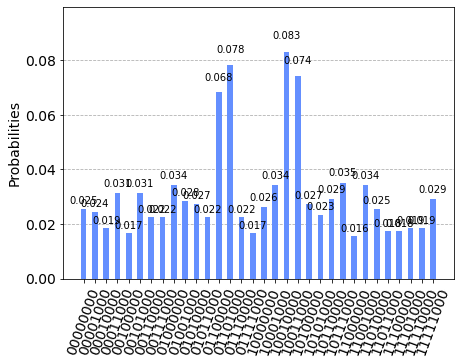

In [44]:
qbraid_aws_result = qbraid_aws_job.result()
qbraid_aws_result.plot_counts()

In [45]:
# sort by most probable soltuion based on the counts from the simulation
fResults = qbraid_aws_result.measurement_counts()
sortF = dict(sorted(fResults.items(), key=lambda item: item[1]))
res =dict(reversed(list(sortF.items())))

# get the best one:
oneSolution =  list(res)[0]

# convert it to the form we need:
solution = [4]
for i in range(2):
    val = (int)(oneSolution[i*2])+(int)(oneSolution[i*2+1])*2
    solution.append(val)

# to construct the solution we add the remaining nodes on the already established rule
# they have the same starting bit as the ones from one bit before and have different second-bit value 
# (this is the reason we convert it using 1-(int)(oneSolution[i*2])
for i in range(2):
    solution.append((1-(int)(oneSolution[i*2]))+(int)(oneSolution[i*2+1])*2)

solution.append(4)

solution_vis.append(solution)

print(solution)


[4, 1, 2, 0, 3, 4]


In [46]:
is_hamiltonian_cycle(graph, solution)

Success: path is a Hamiltonian cycle


True

As we can see, we have another good solution provided through AWS Braket.

## Visualisation

We think that it might be fun to visualize the different solutions the algorithm picked using the different arhitecture/simulators, therefore the following code highligts on the graph the edges that a certain algorithm chose

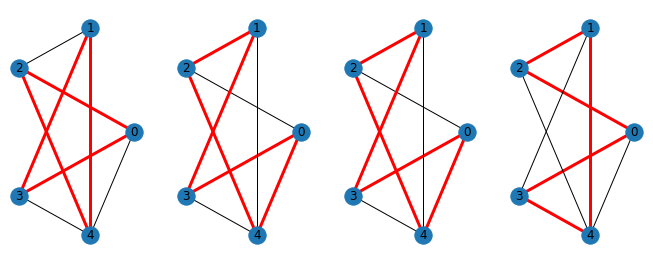

In [67]:
f = plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plotC = 1

edges_g = [(0, 4), (0, 3), (0, 2), (1, 2), (1, 4), (1, 3), (2, 4), (3, 4)]

pos = {0: (50, 50), 1: (50, 40), 2: (20, 20), 3: (20, 30), 4: (30, 30)}

for sol in solution_vis:
    graph_copy = nx.Graph()
    graph_copy.add_nodes_from(pos.keys())
   
    for i in range(len(sol)-1):
        graph_copy.add_edge(sol[i],sol[i+1],color='red', weight=3)
    for (x, y) in edges_g:
        if not graph_copy.has_edge(x, y):
            graph_copy.add_edge(x,y,color='black', weight=1)
    
    edges = graph_copy.edges()
    colors = [graph_copy[u][v]['color'] for u,v in edges]
    weights = [graph_copy[u][v]['weight'] for u,v in edges]
    
    nodePos = nx.circular_layout(graph_copy)
    plt.subplot(4, 6, plotC)
    plotC+=1
    # pos = nx.random_layout(graph_copy)
    # nx.draw(graph_copy, with_labels=True)
    nx.draw(graph_copy, edge_color=colors, pos=nodePos, width=weights, with_labels = True)
    if plotC > 24:
        break
    
    

The drawings above show the cycles found by the grover search after simulating it on different arhitecture/simulators.
From left to right: <br>
*{14 qubits, IBMQ simulator}, {14 qubits, AWS Braket simulator}, {8 qubits, IBMQ simulator}, {8 qubits, AWS Braket simulator}*

We can see that while the cycles selected are different depending on simulator and arhitecture, they are all viable solutions for the given graph:

In [68]:
for sol in solution_vis:
    is_hamiltonian_cycle(graph, sol)

Success: path is a Hamiltonian cycle
Success: path is a Hamiltonian cycle
Success: path is a Hamiltonian cycle
Success: path is a Hamiltonian cycle


# Discussions

We think that the comparison between the two solutions we provided is nicely summarised by the following table:

| Criteria | First solution: 14 qubits | Second solution: 8 qubits |
| --- | --- | --- |
| <b>Pros:</b> |  returns all the possible hamiltonian cycles from the graph |  smaller circuit that can be simulated (faster) |
| <b>Cons:</b> |  requires more gates and qubits to run |  returns only part of the solutions for the problem |
| <b>Generalize?</b> |  might be easier to generalize on a smaller graph if the oracle is implemented using the edges |  harder to apply to other problems |



<br><br>While the first implementation seems to be easier to expand to a more general solution as well as giving us all the possible cycles from the graph it has one downfall: the depth of the circuit is quite large. This can be a problem, for example we weren't able to get it to run on the SV1 simulator since the toffoli gate implemented in qiskit required more qubits to implement in braket than available at the time. The second solution on the other hand, while utilising a smaller circuit, it seems to us that is constructed to work especially well on this task, and might not be scalable for a more general solution (also, is reliable to give only part of the solutions, so not quite good for a more general task of finding all the hamiltonian cycles)